In [1]:
### https://anaconda.org/anaconda/py-xgboost
### Importando as libs
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import confusion_matrix, mean_squared_error
import pylab as pl
from sklearn import model_selection
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

# Scripts

In [2]:
def forward_feature_construction(colunasx,colunasy):
    ### Config
    size = len(colunasx)
    lista = list()
    for id in  range(1,size):
        for x in  combinations(colunasx,r=id):
            lista.append(list(x))
        ### Resampling
    return lista    

In [3]:
def predict(lista, train, colunasy,teste_size):
    ### Config
    acertos=0
    colunas=[]
    #seed = 9
    resultXGBClassifier=0
    for max_depth in  range(3,10):
        for seed in  range(1,15):
            for colunasx in  lista:
                ### Slice
                x_treino, x_teste, y_treino, y_teste = model_selection.train_test_split(train[colunasx],train[colunasy],test_size=teste_size,random_state=seed)
                ### Modelo - Treino
                xgb_model = xgb.XGBClassifier(max_depth=max_depth).fit(x_treino, y_treino)
                ### Modelo - Predict
                predictions = xgb_model.predict(x_teste)
                ### Confusion Matrix
                actuals = y_teste
                #print(colunasx)
                #print(confusion_matrix(actuals, predictions))
                previsto = pd.DataFrame({'previsto':predictions},index=actuals.index)
                resultadoErros =       previsto.loc[previsto['previsto'].values != actuals['Sobreviventes'].values]
                resultadoAcertos =     previsto.loc[previsto['previsto'].values == actuals['Sobreviventes'].values]
                #print('Acertos',resultadoAcertos.size)
                #print('Predict',x_teste_dropna.shape)
                #print('Erros',resultadoErros.shape)
                if resultadoAcertos.size > acertos:
                    resultXGBClassifier = xgb_model.score(x_teste,y_teste)
                    acertos=resultadoAcertos.size
                    colunas=colunasx
                    seedfinal=seed
                    max_depthFinal=max_depth
    print('Score XGBClassifier:',(resultXGBClassifier*100.0))
    return (acertos,colunas,seedfinal,max_depthFinal)


    

# Coleta de dados

## Fontes

In [4]:
### Coletando as fontes de dados
test_csv = pd.read_csv('r_teste.csv', sep = ',', encoding = 'UTF-8',header='infer')
train_csv = pd.read_csv('r_treino.csv', sep = ',', encoding = 'UTF-8',header='infer')
train_dropna_csv = pd.read_csv('r_treino_dropna.csv', sep = ',', encoding = 'UTF-8',header='infer')

In [5]:
train_dropna_csv.head(2)

,PassageiroId,Classe,ParentesIrmao,ParentesFilhos,SexoNum,SaudacaoNum,PassagemPreco,FamiliaQtde,Sobreviventes
0,1,3,1,0,1,0,7.2500,1,0
1,2,1,1,0,0,1,71.2833,1,1


In [6]:
colunasx=[
    'Classe',
    'PortoEmbarqueNum',
    'ParentesIrmao',
    'ParentesFilhos',
    'FamiliaQtde',
    'PassagemPreco',
    'SexoNum',
    'SaudacaoNum'   
]
colunasy=['Sobreviventes']

In [7]:
colunas = forward_feature_construction(colunasx,colunasy)

In [8]:
#train_dropna_csv=train_dropna_csv.set_index(train_dropna_csv['PassageiroId'])
train= train_dropna_csv
#train= train_csv
train=train.set_index(train['PassageiroId'])

In [9]:
### Config
teste_size=0.35 ##30%

In [10]:
acertos,colunas,seed,max_depth=predict(colunas, train, colunasy,teste_size)

Score XGBClassifier: 85.2


In [11]:
acertos

213

In [12]:
colunas

['Classe', 'ParentesFilhos', 'FamiliaQtde', 'SaudacaoNum']

In [13]:
seed

13

In [14]:
max_depth

3

# Resultado Final

In [15]:
x_treino, x_teste, y_treino, y_teste = model_selection.train_test_split(train[colunas],train[colunasy],test_size=teste_size,random_state=seed)
#x_treino, x_teste, y_treino, y_teste = model_selection.train_test_split(train[colunas],train[colunasy],test_size=0,random_state=seed)

In [16]:
xgb_model = xgb.XGBClassifier(max_depth=max_depth).fit(x_treino, y_treino)
#xgb_model = xgb.XGBClassifier(max_depth=3).fit(x_treino, y_treino)

In [17]:
y_pred_dropna = xgb_model.predict(test_csv[colunas])

In [18]:
submission = pd.DataFrame({
        "PassengerId": test_csv["PassageiroId"],
        "Survived": y_pred_dropna
    })
submission.to_csv('resultXGBClassifier_dropna.csv', index=False)

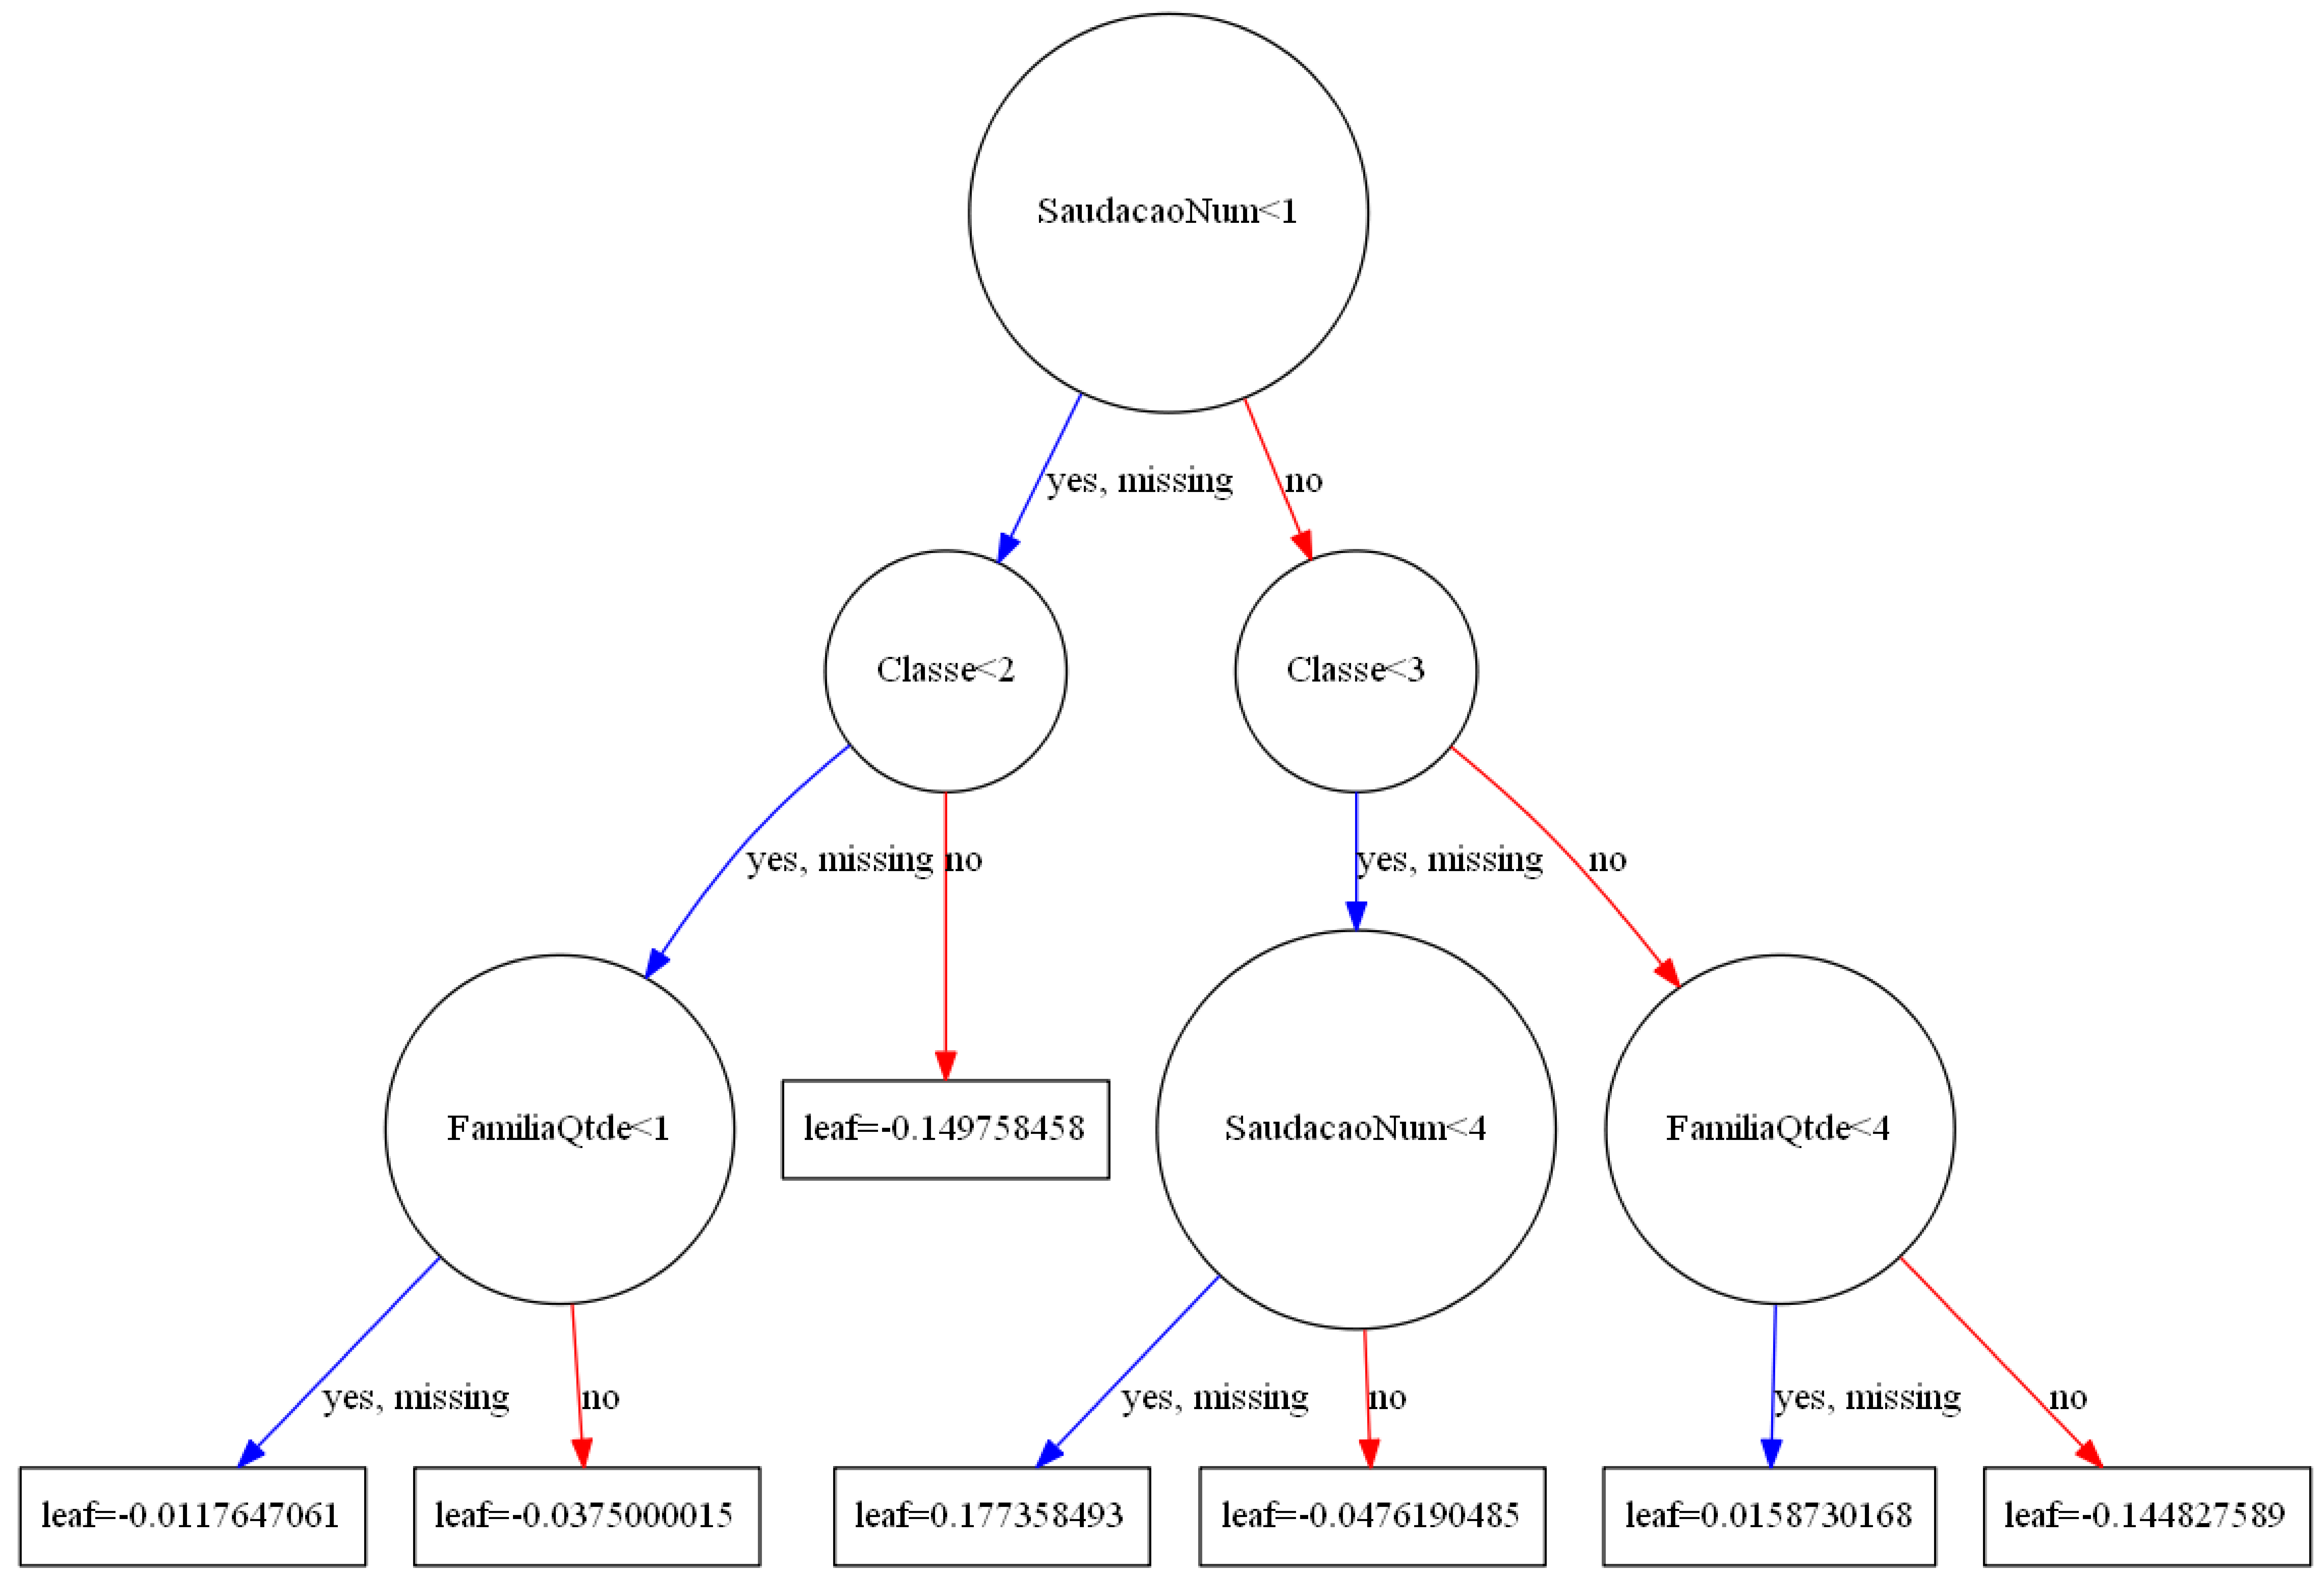

In [19]:
xgb.plot_tree(xgb_model)
fig = pl.gcf()
fig.set_size_inches(150, 100)